통계 방법
1. 회차별 보너스 포함 당첨번호를 집계해서 최근 2주간, 최근 3개월간 등 원하는 기간 내에 당첨번호가 몇개 나오는지 통계
2. 번호별로 당첨이 몇번 됐는지 확인

번호뽑기
1. 각 번호는 당첨횟수만큼 백분율로 환산하여 가중치를 갖는다. (번호가중치)

ex) 100% 중에서 0부터 0.01은 번호 1,
    0.01부터 0.02는 번호 2를 가리킨다

2. 최근 한달간, 최근 3개월간, 최근 6개월간의 당첨번호를 통계내어
1-9, 10-19, 20-29, 30-39, 40-45 각 구간의 백분율로 환산된만큼 가중치를 갖는다. (기간가중치)

ex) 100% 중에서 0부터 0.1은 1-9 구간,
0.1부터 0.3은 10-19 구간을 가리킨다

3. 번호를 뽑을 때 0과 1사이의 랜덤값에 번호뽑기 1,2번에서 나온 가중치를 반영하여 번호를 뽑고 이 과정으로 총 6개의 번호를 뽑는다.

4. 이 스크립트는 입력값 n을 받고 n만큼 번호를 뽑을 수 있다.
6개의 번호를 n번 뽑는 것이다.

In [21]:
pip install requests beautifulsoup4

# 최근 회차까지의 데이터셋 저장

In [22]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import math
import random
from collections import defaultdict

last_round = 1153
url = "https://dhlottery.co.kr/gameResult.do?method=allWinPrint&gubun=byWin&nowPage=&drwNoStart=1&drwNoEnd="+str(last_round)

response = requests.get(url)
response.encoding = 'euc-kr'  # 동행복권 사이트는 euc-kr 인코딩 사용
html = response.text
soup = BeautifulSoup(html, 'html.parser')

table = soup.find("table", {"class": "tbl_data tbl_data_col"})
rows = table.find_all("tr")[1:]  # 1행 이후부터 데이터

lotto_data = []
for row in rows:
    cols = row.find_all("td")
    if len(cols) < 3:
        continue

    # (1) 회차
    # "1153회"처럼 되어 있으면, 숫자 이외 문자는 제거하여 int 변환
    draw_no_text = cols[0].text.strip()
    draw_no_text = re.sub(r'[^0-9]', '', draw_no_text)  # 숫자 외 모두 제거
    draw_no = int(draw_no_text)  # 정수 변환

    # (2) 당첨번호 + 보너스번호 (하나의 리스트로 묶음)
    # - '\n' 제거
    # - 숫자와 공백 외 문자는 제거
    numbers_text = (cols[1].text+cols[2].text).strip()
    numbers_text = re.sub(r'[^0-9\s]', '', numbers_text) # 숫자/공백 외 제거

    # 공백 기준 split → 정수화
    all_numbers = numbers_text.split()
    all_numbers = list(map(int, all_numbers))

    lotto_data.append({
        "회차": draw_no,
        "번호": all_numbers
    })

# 판다스 DataFrame으로 변환
df = pd.DataFrame(lotto_data)

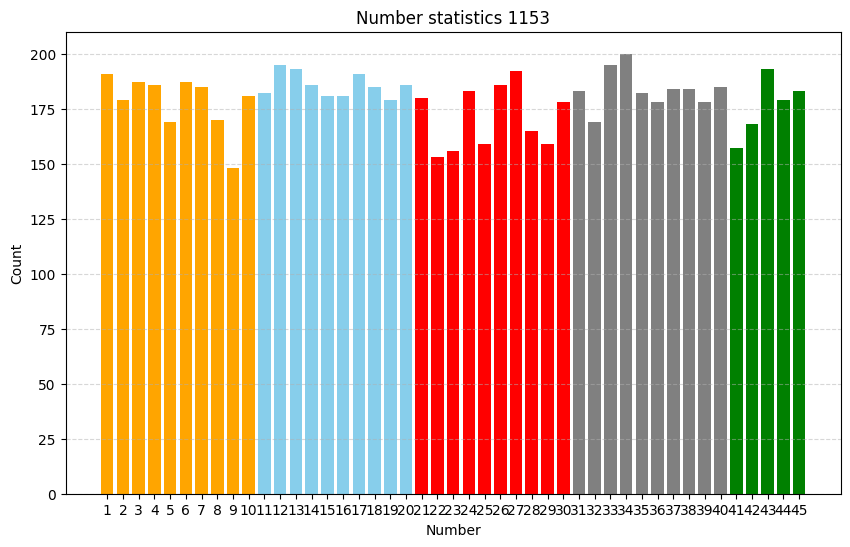

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

matplotlib.rcParams['font.family'] = 'DejaVu Sans'

def get_number_counts_total(df):
    """
    df 전체를 대상으로, 각 번호(1~45)가 몇 번 등장했는지 반환
    return: {번호: 출현 횟수}
    """
    number_counts = defaultdict(int)
    for _, row in df.iterrows():
        for num in row["번호"]:
            number_counts[num] += 1
    return dict(number_counts)

# 구간별 색깔 매핑
def get_color_for_number(num):
    if 1 <= num <= 10:
        return "orange"
    elif 11 <= num <= 20:
        return "skyblue"
    elif 21 <= num <= 30:
        return "red"
    elif 31 <= num <= 40:
        return "gray"
    else:  # 40~45
        return "green"

# 예: df가 (회차, 번호[]) 형태라고 가정
counts_dict = get_number_counts_total(df)
counts_series = pd.Series(counts_dict).sort_index()

# 각 막대(bar)에 대응하는 색깔 리스트 만들기
colors_for_bars = [get_color_for_number(num) for num in counts_series.index]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(counts_series.index, counts_series.values, color=colors_for_bars)

plt.title("Number statistics "+str(last_round))
plt.xlabel("Number")
plt.ylabel("Count")
plt.xticks(range(1, 46))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# 번호 가중치 계산

In [24]:
def get_number_counts_in_range(df, start_round=None, end_round=None):
    """
    df: DataFrame (회차, 번호)
    start_round: 조회 시작 회차 (None이면 가장 처음 회차)
    end_round: 조회 끝 회차 (None이면 가장 마지막 회차)

    return: {번호: 출현 횟수} 딕셔너리
    """
    # 회차 범위 지정 (None이면 전체 범위 중 최소~최대)
    if start_round is None:
        start_round = df["회차"].min()
    if end_round is None:
        end_round = df["회차"].max()

    # 해당 회차 범위 내 데이터만 필터
    mask = (df["회차"] >= start_round) & (df["회차"] <= end_round)
    sub_df = df[mask]

    # 번호별 출현 횟수 계산
    from collections import defaultdict
    number_counts = defaultdict(int)

    for _, row in sub_df.iterrows():
        # row["번호"]는 7개(당첨번호6 + 보너스1)
        for num in row["번호"]:
            number_counts[num] += 1

    return dict(number_counts)

def get_number_counts_total(df):
    """
    df 전체를 대상으로 번호별 출현 횟수 반환
    """
    return get_number_counts_in_range(df, None, None)

def get_number_weights(df, start_round=None, end_round=None):
    """
    start_round, end_round 범위에서
    번호별 출현 횟수 -> 출현 비율(= 가중치)로 계산

    return: {번호: 가중치} 딕셔너리 (합이 1)
    """
    counts = get_number_counts_in_range(df, start_round, end_round)

    # 전체 출현 횟수
    total_count = sum(counts.values())
    if total_count == 0:
        # 혹시 해당 구간에 아무 데이터가 없으면 (예: 잘못된 회차)
        # 모든 번호의 가중치를 0으로 두거나, 1/45 균등분포로 처리
        return {n: 1/45 for n in range(1,46)}

    # 번호(1~45)에 대해, 없으면 0으로 처리
    weights = {}
    for num in range(1, 46):
        cnt = counts.get(num, 0)
        weights[num] = cnt / total_count

    return weights

# 기간 가중치 계산

In [25]:
def get_range_counts_in_interval(df, start_round, end_round):
    """
    start_round~end_round 범위에서
    1~9, 10~19, 20~29, 30~39, 40~45 구간별 출현 횟수 반환

    return: { '1~9': cnt, '10~19': cnt, '20~29': cnt, '30~39': cnt, '40~45': cnt }
    """
    counts = get_number_counts_in_range(df, start_round, end_round)

    # 구간 초기화
    intervals = {
        '1~9': 0,
        '10~19': 0,
        '20~29': 0,
        '30~39': 0,
        '40~45': 0
    }

    for num, c in counts.items():
        if 1 <= num <= 9:
            intervals['1~9'] += c
        elif 10 <= num <= 19:
            intervals['10~19'] += c
        elif 20 <= num <= 29:
            intervals['20~29'] += c
        elif 30 <= num <= 39:
            intervals['30~39'] += c
        elif 40 <= num <= 45:
            intervals['40~45'] += c

    return intervals

def get_interval_weights(df, start_round, end_round):
    """
    start_round~end_round 범위에서,
    1~9, 10~19, 20~29, 30~39, 40~45 구간별 비율 -> 번호별 기간 가중치

    예) 1~9 구간이 전체 120회 중 20회라면 = 0.166..,
        해당 구간 번호(1~9)는 기간 가중치 0.166..을 공통으로 갖음.

    return: {번호: 해당 구간의 비율} (합계=1이 아님. 구간 비율이므로)
    """
    intervals_count = get_range_counts_in_interval(df, start_round, end_round)
    total = sum(intervals_count.values())
    if total == 0:
        # 해당 범위에 데이터가 없으면, 모든 번호 동일 취급
        return {n: 1 for n in range(1,46)}

    # 구간별 비율
    interval_ratios = {}
    for k in intervals_count:
        interval_ratios[k] = intervals_count[k] / total

    # 번호별로 매핑
    interval_weight = {}
    for num in range(1, 46):
        if 1 <= num <= 9:
            interval_weight[num] = interval_ratios['1~9']
        elif 10 <= num <= 19:
            interval_weight[num] = interval_ratios['10~19']
        elif 20 <= num <= 29:
            interval_weight[num] = interval_ratios['20~29']
        elif 30 <= num <= 39:
            interval_weight[num] = interval_ratios['30~39']
        else:
            interval_weight[num] = interval_ratios['40~45']

    return interval_weight


def combine_weights(num_weight, interval_weight):
    """
    두 종류의 가중치(번호별 dict)를 곱한 뒤, 전체 합이 1이 되도록 정규화
    num_weight: {번호: w1}
    interval_weight: {번호: w2}
    return: {번호: 최종가중치}
    """
    combined = {}
    for n in range(1, 46):
        w1 = num_weight.get(n, 0)
        w2 = interval_weight.get(n, 0)
        combined[n] = w1 * w2

    total = sum(combined.values())
    # 모두 0이라면(특정 구간에 데이터가 없어서 0이 된 경우) → 균등분포
    if math.isclose(total, 0.0):
        return {n: 1/45 for n in range(1,46)}

    # 정규화
    for n in combined:
        combined[n] /= total

    return combined

In [26]:
def pick_one_number(weight_dict):
    """
    weight_dict: {번호: 가중치} (가중치 합=1)
    0~1 난수를 발생시키고, 해당 범위에 속하는 번호를 반환
    """
    r = random.random()  # 0 <= r < 1
    cumulative = 0.0

    for num, w in weight_dict.items():
        cumulative += w
        if r <= cumulative:
            return num

    # 혹시 부동소수점 문제 등으로 마지막에 걸리는 경우
    return list(weight_dict.keys())[-1]

def pick_six_numbers(final_weights):
    """
    final_weights: {번호: 최종가중치} (1~45)
    6개 번호를 중복 없이 뽑는다.
    return: 오름차순 정렬된 6개의 번호 리스트
    """
    picked = []
    temp_weights = final_weights.copy()

    for _ in range(6):
        num = pick_one_number(temp_weights)
        picked.append(num)
        # 뽑힌 번호의 가중치를 0으로 변경
        temp_weights[num] = 0.0
        # 다시 합계를 구해 정규화
        s = sum(temp_weights.values())
        if s > 0:
            for k in temp_weights:
                temp_weights[k] /= s

    return sorted(picked)

def draw_numbers_n_times(df, n,
                         num_weight_range=None,   # (start,end) for 번호가중치 구간
                         interval_weight_range=None, # (start,end) for 기간가중치 구간
                         interval_name="최근3개월"):
    """
    n번(각 6개씩) 뽑아서 결과를 리스트로 반환
    num_weight_range: (start_round, end_round)
    interval_weight_range: (start_round, end_round)
    interval_name: 디버깅/출력용 설명
    """
    # 1) 번호 가중치
    if num_weight_range is None:
        # 전체 범위
        w_num = get_number_weights(df, None, None)
    else:
        w_num = get_number_weights(df, num_weight_range[0], num_weight_range[1])

    # 2) 기간(구간) 가중치
    if interval_weight_range is None:
        # 예: 최근 12회 라고 가정
        latest_round = df["회차"].max()
        start_round = latest_round - 11  # 12회 분량
        w_interval = get_interval_weights(df, start_round, latest_round)
    else:
        w_interval = get_interval_weights(df, interval_weight_range[0], interval_weight_range[1])

    # 3) 최종 가중치
    final_weights = combine_weights(w_num, w_interval)

    # 4) n번 뽑기
    results = []
    for i in range(n):
        picked_6 = pick_six_numbers(final_weights)
        results.append(picked_6)

    # 예시 출력
    print(f"[{interval_name}] 번호뽑기 결과 (총 {n}번):")
    for idx, nums in enumerate(results, start=1):
        print(f"{idx}회차 뽑기: {nums}")

    return results

# 번호 뽑기

In [27]:
# 예: 전체 번호가중치 × 최근 12회(3개월 가정) 구간가중치
res = draw_numbers_n_times(df, n=5,
                           num_weight_range=None,  # 전체 범위
                           interval_weight_range=None,  # 최근 12회
                           interval_name="최근12회")

[최근12회] 번호뽑기 결과 (총 5번):
1회차 뽑기: [5, 23, 32, 35, 37, 42]
2회차 뽑기: [6, 16, 18, 23, 31, 34]
3회차 뽑기: [1, 8, 31, 33, 38, 41]
4회차 뽑기: [4, 6, 13, 15, 33, 38]
5회차 뽑기: [1, 2, 25, 27, 37, 38]


# 여러 기간 가중치 합산하여 계산

In [31]:
def get_interval_weights_multiple(df, intervals_configs):
    """
    intervals_configs: 리스트 형태로, 각 요소에
       {
         'start_round': int,
         'end_round': int,
         'weight': float  # 이 구간에 부여할 가중치(예: 0.5)
       }
    를 담아둔다.

    해당 구간들의 interval_weights를 구해 각각 weight만큼 곱해 합산한 뒤,
    최종적으로 정규화하여 {번호: 최종기간가중치}를 반환한다.
    """

    # (1) 일단 0으로 초기화
    combined = {num: 0.0 for num in range(1, 46)}

    # (2) 구간별로 loop
    for cfg in intervals_configs:
        st = cfg["start_round"]
        en = cfg["end_round"]
        w = cfg["weight"]

        # 2-1) 단일 구간에 대한 interval_weights 구함
        interval_w = get_interval_weights(df, st, en)  # {번호: 구간 비율}

        # 2-2) 구한 값에 weight를 곱해 combined에 누적
        for num in range(1, 46):
            combined[num] += interval_w[num] * w

    # (3) 정규화 (합이 0이면(=모두 0이면) 균등분포 가정)
    total = sum(combined.values())
    if math.isclose(total, 0.0):
        # 아무 데이터가 없다면 균등분포
        return {n: 1/45 for n in range(1,46)}

    for num in range(1, 46):
        combined[num] /= total

    return combined


def draw_numbers_n_times_custom(df, n):

    w_num = get_number_weights(df, None, None)

    latest_round = df["회차"].max() # 최근 1개월, 3개월, 6개월 가중치 합산
    intervals_configs = [
        {"start_round": latest_round-3, "end_round": latest_round, "weight": 0.5},   # 최근 1개월
        {"start_round": latest_round-11, "end_round": latest_round, "weight": 0.3},  # 최근 3개월
        {"start_round": latest_round-23, "end_round": latest_round, "weight": 0.2}   # 최근 6개월
    ]
    multi_interval_weight = get_interval_weights_multiple(df, intervals_configs)

    final_weights = combine_weights(w_num, multi_interval_weight)

    results = []
    for i in range(n):
        picked_6 = pick_six_numbers(final_weights)
        results.append(picked_6)

    print(f"커스텀 번호뽑기 결과 (총 {n}번):")
    for idx, nums in enumerate(results, start=1):
        print(f"{nums}")

    return results

# 여러 가중치 합산한 번호 뽑기

In [32]:
res = draw_numbers_n_times_custom(df, n=10)

커스텀 번호뽑기 결과 (총 10번):
[17, 23, 30, 36, 38, 39]
[6, 24, 25, 30, 32, 38]
[1, 9, 16, 26, 28, 39]
[1, 3, 4, 12, 30, 41]
[7, 11, 33, 38, 39, 43]
[16, 25, 30, 34, 35, 45]
[5, 7, 12, 16, 24, 40]
[6, 7, 16, 30, 36, 38]
[4, 6, 8, 26, 34, 39]
[1, 3, 4, 6, 16, 33]
